# Trapped ion device from University of Mainz benchmarking

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))

benchmarking_data_dir = notebook_path+'/mainz_device_benchmarking'
benchmarking_data = pd.read_json(benchmarking_data_dir+'/trapped_ion_benchmarking_data.json')

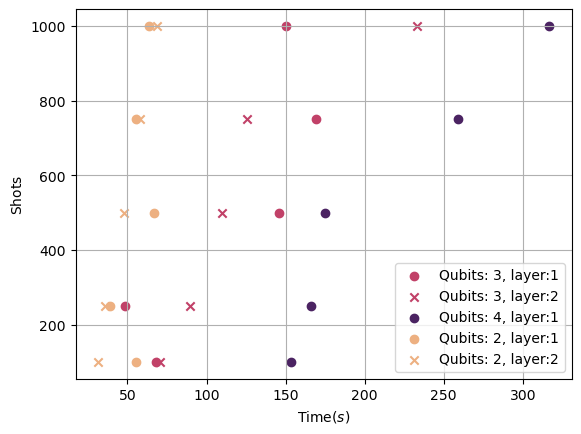

In [2]:
plt.rcParams.update({
  "text.usetex": False,
  #"font.family": "Helvetica"
})
markers_dict = {1: 'o', 2: 'x'}
cmap = plt.get_cmap('flare')

for qb in benchmarking_data.nqubits.unique():
    qb_filt=benchmarking_data[benchmarking_data['nqubits']==qb]
    norm = plt.Normalize(benchmarking_data['nqubits'].min(), benchmarking_data['nqubits'].max())
    color = cmap(norm(qb))  # Map qubit value to a color using the colormap
    for layer in qb_filt.layers.unique():
        layer_filt=qb_filt[qb_filt['layers']==layer]

        xs=layer_filt.time_elapsed
        ys=layer_filt.shots
        
        plt.scatter(x=xs, y=ys, marker=markers_dict[layer], label=f'Qubits: {qb}, layer:{layer}', color=color)
plt.ylabel(r'$\text{Shots}$')
plt.xlabel(r'$\text{Time}(s)$')
plt.legend()
plt.grid(True)
plt.savefig(notebook_path+'/mainz_device_benchmarking/mainz_dev_time_cost_benchmarking.pdf')
plt.show()

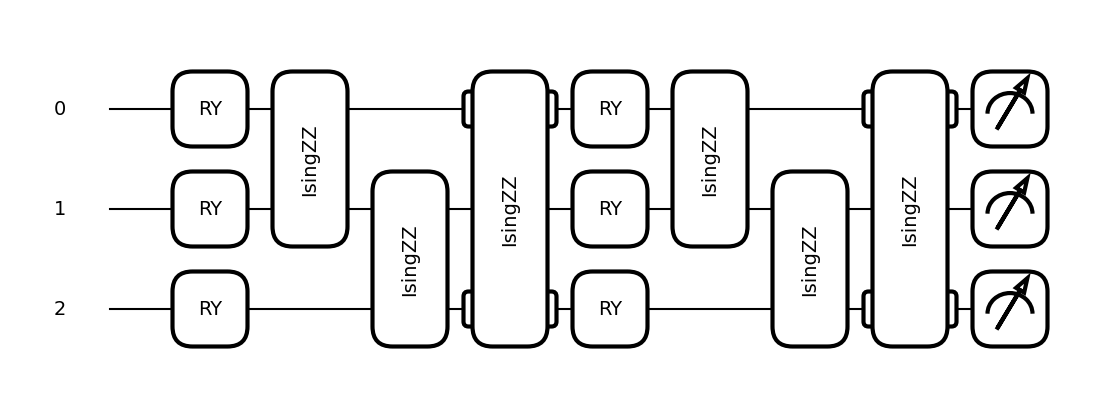

In [3]:
nqubits=3
layers=2
shots=1000
dev = qml.device('default.qubit', shots=shots, wires=nqubits)
@qml.qnode(dev)
def ansatz_for_mainz(params):
    for layer in range(layers):
        for wire in dev.wires:
            qml.RY(params[wire][layer], wires=wire)
        for wire in dev.wires:
            qml.IsingZZ(np.pi/2, wires=[wire, (wire+1)%nqubits])

    return [qml.expval(qml.PauliZ(wires=wire)) for wire in range(nqubits)]

init_params = np.random.rand(nqubits, layers)
#fig, ax object tuple
fig0, ax0 =qml.draw_mpl(ansatz_for_mainz)(init_params)
fig0.savefig(notebook_path+'/mainz_device_benchmarking/mainz_benchmarking_circuit.pdf')


In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Phase functions of expectation values in different VQE parameters (3 qubit circuit)

In [5]:
import os
#import seaborn as sns
import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))
vpe_data_path_3qb = notebook_path+'/mainz_phase_fn_data/trapped_ion_redtrap_size3/system_size_3'

vpe_data_3qb = pd.read_json(vpe_data_path_3qb+'/3_qubit_trapped_ion_data.json')

In [6]:
unique_params_3qb=[]
unique_obs_3qb=vpe_data_3qb.observable.dropna().unique()
for item in vpe_data_3qb.parameter.dropna().items():
    if item[1] not in unique_params_3qb:
        unique_params_3qb.append(item[1])
print("Unique parameters: \n", unique_params_3qb)
print("Unique observables: \n", unique_obs_3qb)
print(f"Number of shots allocated to the quantum device: {int(vpe_data_3qb.device_shots.dropna().unique()[0])}")

Unique parameters: 
 [[-9.4247779608, 4.1908845999], [-6.2831853072, 2.7939230666], [-3.1415926536, 1.3969615333], [0.0, 0.0], [3.1415926536, -1.3969615333], [6.2831853072, -2.7939230666], [9.4247779608, -4.1908845999]]
Unique observables: 
 ['1.0 [Z0 Z1]' '1.0 [Z0]']
Number of shots allocated to the quantum device: 6000


In [7]:
an_space=np.linspace(-2*np.pi, 2*np.pi, num=100)
dat_space=np.linspace(-2*np.pi, 2*np.pi, num=7)
full_space=sorted([*dat_space, *an_space])

def ansatz3(params, wires=range(3)):
    params=params*np.array([1.5,-0.667])
    qml.PauliX(wires=[0])
    qml.SingleExcitation(params[0], wires=[0,1])
    qml.SingleExcitation(params[1], wires=[1,2])

dev2=qml.device('default.qubit', shots=None, wires=3)
@qml.qnode(dev2)
def circ2(params, obs):
    ansatz3(params, wires=range(3))
    if obs=='1.0 [Z0]':
        return qml.expval(qml.PauliZ(0))       
    elif obs=='1.0 [Z0 Z1]':
        return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))
    else:
        raise ValueError('Wrong observable')

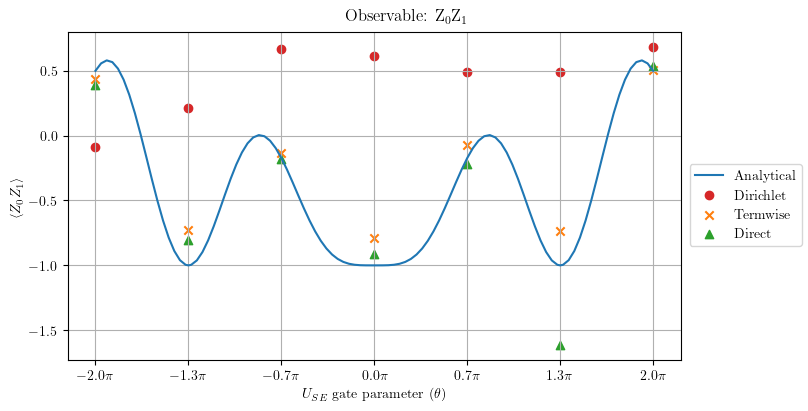

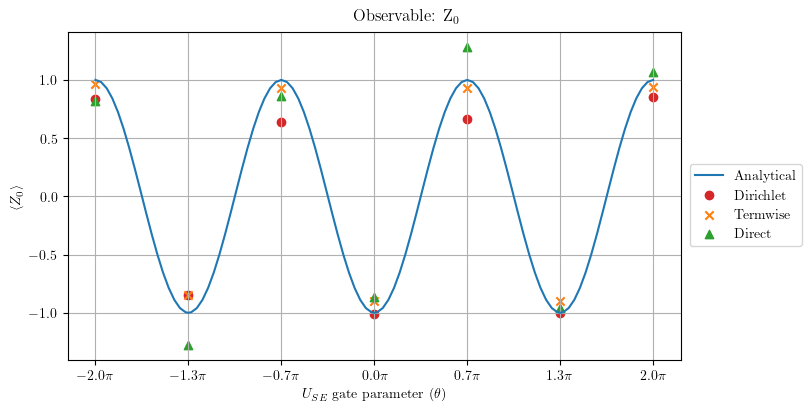

In [8]:
from pathlib import Path


for obs in vpe_data_3qb.observable.dropna().unique():
    dirichlet_data_3qb=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[0]) & (vpe_data_3qb['observable']==obs)]
    direct_data_3qb=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[1]) & (vpe_data_3qb['observable']==obs)]
    dirichlet_vpe_expvals_3qb=dirichlet_data_3qb['cfvpe_expvals'].dropna()
    direct_vpe_expvals_3qb=direct_data_3qb['cfvpe_expvals'].dropna()
    termwise_expvals_3qb=direct_data_3qb['termwise_expvals'].dropna() #termwise expectation values are the same for both data sets
    #expvals_list[str(expval_meth+'_'+obs)]=expvals
    params_3qb=direct_data_3qb['parameter'].dropna() #the evaluation of the expectation 
    #pars[str(expval_meth+'_'+obs)]=params
    param_sweep_space_3qb = np.linspace(-2*np.pi, 2*np.pi, num=len(params_3qb))
    an_param_sweep_space_3qb = np.linspace(-2*np.pi, 2*np.pi, num=100)
    an_param_sweep_space_3qb = sorted([*param_sweep_space_3qb, *an_param_sweep_space_3qb])
    an_expvals_3qb=[circ2(x, obs) for x in an_param_sweep_space_3qb]

    fig1, ((ax1)) = plt.subplots(1,1,  figsize=(8,4),layout='constrained',sharey=True, sharex=True)
    ax1.plot(an_param_sweep_space_3qb,an_expvals_3qb, linestyle='-',color='tab:blue', label=r'$\textrm{Analytical}$')
    ax1.scatter(param_sweep_space_3qb, dirichlet_vpe_expvals_3qb, color='tab:red', marker='o', label=r'$\textrm{Dirichlet}$')
    #ax1.set_title(r'$\textrm{3-qubit circuit}$')
    ax1.scatter(param_sweep_space_3qb, termwise_expvals_3qb, color='tab:orange', marker='x', label=r'$\textrm{Termwise}$')# label='Measured expectation values')
    ax1.scatter(param_sweep_space_3qb, direct_vpe_expvals_3qb, color='tab:green', marker='^', label=r'$\textrm{Direct}$')

    ax1.grid(True)
    fig1.legend(loc='outside right')
    if obs=='1.0 [Z0]':
        fig1.suptitle(r'$\textrm{Observable: Z}_0$')
        ax1.set_ylabel(r'$\langle Z_0 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 \rangle $')
    else:
        fig1.suptitle(r'$\textrm{Observable: Z}_0\textrm{Z}_1$')
        ax1.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
        #ax3.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
    #custom ticks
    pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,1))
    tick_labels_3qb = [pi_formatter(x) for x in param_sweep_space_3qb]
    ax1.set_xticks(param_sweep_space_3qb, tick_labels_3qb)
    ax1.set_xlabel(r'$U_{SE}\textrm{ gate parameter }(\theta)$')

    figures_filename= notebook_path+'/mainz_phase_fn_plots/3_qubit_experiments/'+'expvals_3_qb_obs_'+str(obs)+'.pdf'
    Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
    #fig1.set_figwidth(9)
    plt.savefig(figures_filename)
    plt.show()
    #plt.clf()

    


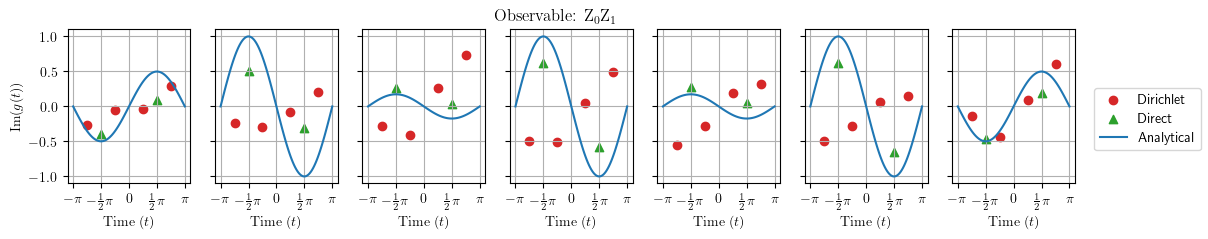

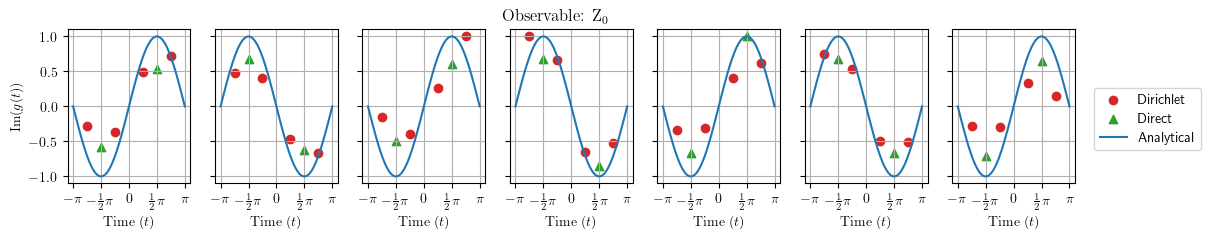

In [9]:
dirichlet_fidelities={}
direct_fidelities={}

direct_vpe_expvals_times={}
direct_vpe_expvals={}
dirichlet_vpe_expvals_times={}
dirichlet_vpe_expvals={}
phase_func_imag_analytic={}

num_linspace_points_analytic = 100
an_times= np.linspace(-np.pi, np.pi, num=num_linspace_points_analytic)

for obs in unique_obs_3qb:
    dirichlet_data=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[0]) & (vpe_data_3qb['observable']==obs)]
    direct_data=vpe_data_3qb[(vpe_data_3qb['expval_method']==vpe_data_3qb.expval_method.dropna().unique()[1]) & (vpe_data_3qb['observable']==obs)]

    for param in unique_params_3qb:
        cached_param_mask_dirichlet=dirichlet_data['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
        cached_param_mask_direct=direct_data['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
        phase_function_mask=direct_data['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
        phase_function_data=direct_data[phase_function_mask]
        cached_dirichlet_data=dirichlet_data[cached_param_mask_dirichlet]
        cached_direct_data=direct_data[cached_param_mask_direct]

        phase_func_imag_analytic[str(param)]=phase_function_data.cfvpe_ref_phase_function_imag_arr.to_numpy()[0]

        dirichlet_fidelities[str(param)]=np.round(cached_dirichlet_data[cached_dirichlet_data['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
        direct_fidelities[str(param)]=np.round(cached_direct_data[cached_direct_data['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)        

        dirichlet_time_mask=cached_dirichlet_data[cached_dirichlet_data['cached_value_str']=='expvalYphased_ps']
        direct_time_mask=cached_direct_data[cached_direct_data['cached_value_str']=='expvalYphased_ps']
        
        dirichlet_expval_collection, direct_expval_collection=[], []
        dirichlet_time_collection, direct_time_collection=[],[]

        for time in direct_time_mask.cached_time.unique():
            direct_expval_collection.append(direct_time_mask[direct_time_mask['cached_time']==time].cached_value.to_numpy()[0])
            direct_time_collection.append(time)
        direct_vpe_expvals[str(param)]=direct_expval_collection
        direct_vpe_expvals_times[str(param)]=direct_time_collection
        
        for time in dirichlet_time_mask.cached_time.unique():
            dirichlet_expval_collection.append(dirichlet_time_mask[dirichlet_time_mask['cached_time']==time].cached_value.to_numpy()[0])
            dirichlet_time_collection.append(time)
        dirichlet_vpe_expvals[str(param)]=dirichlet_expval_collection
        dirichlet_vpe_expvals_times[str(param)]=dirichlet_time_collection

    fig_phases, axes = plt.subplots(1,len(unique_params_3qb), figsize=(2*len(unique_params_3qb),2) ,sharey=True)
    for i, param in enumerate(unique_params_3qb):
        ax=axes[i]
        param_str = str(param)
    
        # Scatter plot for Dirichlet data
        ax.scatter(
            dirichlet_vpe_expvals_times[param_str],
            dirichlet_vpe_expvals[param_str],
            label='Dirichlet'if i==0 else None,
            marker='o',
            color='tab:red'
        )
        
        # Scatter plot for Direct data
        ax.scatter(
            direct_vpe_expvals_times[param_str],
            direct_vpe_expvals[param_str],
            label="Direct" if i==0 else None,
            marker='^',
            color='tab:green'
        )
        ax.plot(an_times, phase_func_imag_analytic[param_str], linestyle='-', color='tab:blue', label='Analytical' if i==0 else "")
        #ax.set_title(f"Parameter: {param_str}")
        ax.set_xlabel(r'$\textrm{Time }(t)$')
        if i == 0:
            ax.set_ylabel(r"$\textrm{Im}(g(t))$")
            
        pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,1))
        tick_labels = [r"$-\pi$",r"$-\frac{1}{2}\pi$",r"$0$",r"$\frac{1}{2}\pi$",r"$\pi$"]#[pi_formatter(x) for x in np.linspace(-np.pi, np.pi, num=5)]
        ax.set_xticks(np.linspace(-np.pi, np.pi, num=5), tick_labels)
        ax.grid(True)
    
    #fig_phases.legend(loc='outside lower center', bbox_to_anchor=(0.5, -0.4))
    fig_phases.legend(loc='right')
    obs_name=r"$\textrm{Z}_0\textrm{Z}_1$" if obs == unique_obs_3qb[0] else r"$\textrm{Z}_0$"
    fig_phases.suptitle(r'$\textrm{Observable: '+obs_name+'}$')
    figures_filename= notebook_path+'/mainz_phase_fn_plots/3_qubit_experiments/'+'phase_funcs_3qb_obs_'+str(obs)+'.pdf'
    Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
    fig_phases.set_figwidth(13)
    plt.savefig(figures_filename, bbox_inches='tight')
    plt.show()

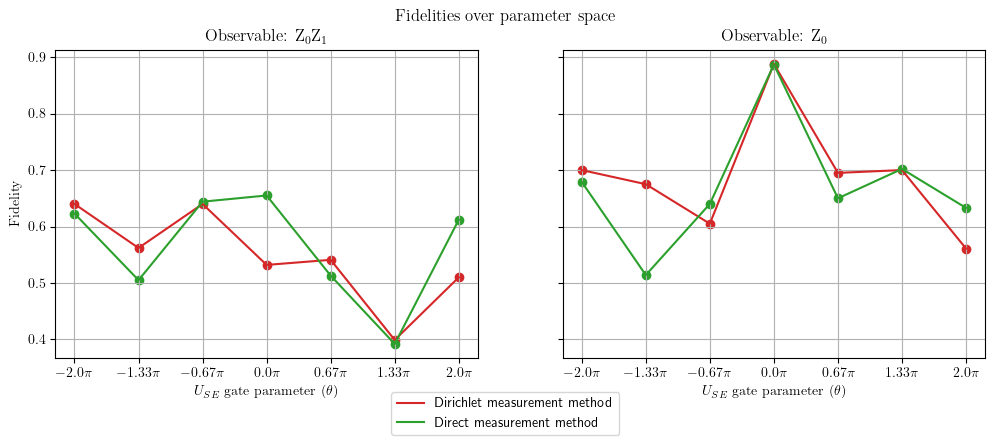

In [10]:
fids=[]
fidelities={}

params_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=7)
params_for_fids=[param for param in params_sweep_space]

fids_for_z0_over_methods={}
fids_for_z0z1_over_methods={}
fids_for_z0_over_params_dirichlet=[]
fids_for_z0_over_params_direct=[]
fids_for_z0z1_over_params_dirichlet=[]
fids_for_z0z1_over_params_direct=[]

for idx, param in enumerate(unique_params_3qb):
    #print(param)
    param_mask=vpe_data_3qb['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    cached_param_mask=vpe_data_3qb['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    #param_filt=vpe_data[vpe_data['parameter']==param]
    param_filt=vpe_data_3qb[param_mask]
    #cached_param_filt=vpe_data[vpe_data['cached_params']==param]
    cached_param_filt=vpe_data_3qb[cached_param_mask]
    for method in param_filt['expval_method'].dropna().unique():
        #method='dirichlet'
        method_filt=param_filt[param_filt['expval_method']==method]
        cached_method_filt=cached_param_filt[cached_param_filt['expval_method']==method]
        for obs in method_filt['observable'].dropna().unique():
            #phase_func_imag_dev[obs]=method_filt[method_filt['observable']==obs].cfvpe_phase_function_imag_arr.to_numpy()[0]
            phase_func_imag_analytic[obs]=method_filt[method_filt['observable']==obs].cfvpe_ref_phase_function_imag_arr.to_numpy()[0]

            cached_obs_filt=cached_method_filt[cached_method_filt['observable']==obs]
            mask=cached_obs_filt[cached_obs_filt['cached_value_str']=='expvalYphased_ps']
            fidelities[obs]=np.round(cached_obs_filt[cached_obs_filt['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
            fids.append(fidelities[obs])

        #print('fidelities:',fidelities)
        fids_for_z0_over_methods[method]=fidelities[unique_obs_3qb[0]]
        fids_for_z0z1_over_methods[method]=fidelities[unique_obs_3qb[1]]
    fids_for_z0_over_params_dirichlet.append(fids_for_z0_over_methods['dirichlet'])
    fids_for_z0_over_params_direct.append(fids_for_z0_over_methods['direct'])
    fids_for_z0z1_over_params_dirichlet.append(fids_for_z0z1_over_methods['dirichlet'])
    fids_for_z0z1_over_params_direct.append(fids_for_z0z1_over_methods['direct'])


fig_dirichlet, (ax1, ax2) = plt.subplots(1,2, sharey=True)

ax1.plot(params_for_fids, fids_for_z0_over_params_dirichlet, linestyle="-", color='tab:red', label="Dirichlet measurement method")
ax1.plot(params_for_fids, fids_for_z0_over_params_direct, linestyle="-", color='tab:green', label="Direct measurement method")
ax1.scatter(params_for_fids, fids_for_z0_over_params_dirichlet, color='tab:red')
ax1.scatter(params_for_fids, fids_for_z0_over_params_direct, color='tab:green')
ax1.set_xlabel(r'$U_{SE}\textrm{ gate parameter }(\theta)$')
ax1.set_ylabel(r'$\textrm{Fidelity}$')
ax1.set_title(r'$\textrm{Observable: Z}_0\textrm{Z}_1$')
assert '1.0 [Z0 Z1]'==unique_obs_3qb[0]

pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,2))
tick_labels = [pi_formatter(x) for x in params_for_fids]
ax1.set_xticks(params_for_fids, tick_labels)
ax1.grid(True)

ax2.plot(params_for_fids, fids_for_z0z1_over_params_dirichlet, linestyle="-", color='tab:red')
ax2.plot(params_for_fids, fids_for_z0z1_over_params_direct, linestyle="-", color='tab:green')
ax2.scatter(params_for_fids, fids_for_z0z1_over_params_dirichlet, color='tab:red')
ax2.scatter(params_for_fids, fids_for_z0z1_over_params_direct, color='tab:green')
ax2.set_xlabel(r'$U_{SE}\textrm{ gate parameter }(\theta)$')

ax2.set_title(r'$\textrm{Observable: Z}_0$')
assert '1.0 [Z0]'==unique_obs_3qb[1]
ax2.set_xticks(params_for_fids, tick_labels)
ax2.grid(True)

fig_dirichlet.suptitle(r'$\textrm{Fidelities over parameter space}$')
fig_dirichlet.legend(bbox_to_anchor=(0.5, -0.1), loc='outside lower center')
fig_dirichlet.set_figwidth(12)
fig_dirichlet.set_figheight(4)
#fig_dirichlet.show()
from pathlib import Path
figures_filename= notebook_path+'/mainz_phase_fn_plots/3_qubit_experiments/'+'fidelities_3qb.pdf'
Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_filename, bbox_inches='tight')
plt.show()

## Phase functions of expectation values in different VQE parameters (2 qubit circuit)

In [11]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

plt.rcParams.update({
  "text.usetex": True,
  #"font.family": "Helvetica"
})

notebook_path = os.path.dirname(os.path.realpath("__file__"))

vpe_data_path_2qb = notebook_path+'/mainz_phase_fn_data/trapped_ion_redtrap_size2/system_size_2'
vpe_data_2qb = pd.read_json(vpe_data_path_2qb+'/2_qubit_trapped_ion_data.json')

In [12]:
unique_params_2qb=[]
unique_obs_2qb=vpe_data_2qb.observable.dropna().unique()
for item in vpe_data_2qb.parameter.dropna().items():
    if item[1] not in unique_params_2qb:
        unique_params_2qb.append(item[1])

print("Unique parameters: \n", unique_params_2qb)
print("Unique observables: \n", unique_obs_2qb)
print(f"Number of shots allocated to the quantum device: {int(vpe_data_2qb.device_shots.dropna().unique()[0])}")

Unique parameters: 
 [[-8.1681408993], [-6.5345127195], [-4.9008845396], [-3.2672563597], [-1.6336281799], [0.0], [1.6336281799], [3.2672563597], [4.9008845396], [6.5345127195], [8.1681408993]]
Unique observables: 
 ['1.0 [Z0 Z1]' '1.0 [Z0]']
Number of shots allocated to the quantum device: 4000


In [13]:
an_space=np.linspace(-2*np.pi, 2*np.pi, num=100)
dat_space=np.linspace(-2*np.pi, 2*np.pi, num=len(unique_params_2qb))
full_space=sorted([*dat_space, *an_space])
#param= [-2*np.pi]

def ansatz2(params, wires=range(2)):
    params=params*np.array([1.3,])
    qml.PauliX(wires=[0])
    qml.SingleExcitation(params[0], wires=[0,1])

dev=qml.device('default.qubit', shots=None, wires=2)
@qml.qnode(dev)
def circ(params, obs):
    ansatz2(params, wires=range(2))
    #return qml.expval(qml.PauliZ(0))
    if obs=='1.0 [Z0]':
        return qml.expval(qml.PauliZ(0))       
    elif obs=='1.0 [Z0 Z1]':
        return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))
    else:
        raise ValueError('Wrong observable')

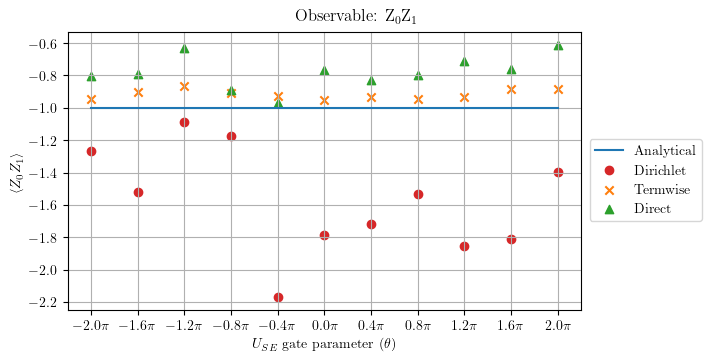

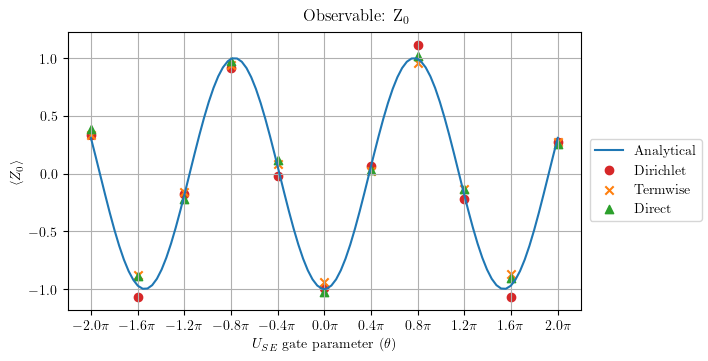

In [14]:
from pathlib import Path

for obs in vpe_data_2qb.observable.dropna().unique():
    dirichlet_data=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[0]) & (vpe_data_2qb['observable']==obs)]
    direct_data=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[1]) & (vpe_data_2qb['observable']==obs)]
    dirichlet_vpe_expvals=dirichlet_data['cfvpe_expvals'].dropna()
    direct_vpe_expvals=direct_data['cfvpe_expvals'].dropna()
    termwise_expvals=direct_data['termwise_expvals'].dropna() #termwise expectation values are the same for both data sets
    params=direct_data['parameter'].dropna() #the evaluation of the expectation 
    param_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=len(params))
    an_param_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=100)
    an_param_sweep_space = sorted([*param_sweep_space, *an_param_sweep_space])
    an_expvals=[circ(x, obs) for x in an_param_sweep_space]

    fig1, ((ax1)) = plt.subplots(1,1,  figsize=(8,4), layout='constrained',sharey=True, sharex=True)
    ax1.plot(an_param_sweep_space,an_expvals, linestyle='-',color='tab:blue',label=r'$\textrm{Analytical}$')
    ax1.scatter(param_sweep_space, dirichlet_vpe_expvals, color='tab:red', marker='o', label=r'$\textrm{Dirichlet}$')

    ax1.scatter(param_sweep_space, termwise_expvals, color='tab:orange', marker='x', label=r'$\textrm{Termwise}$')
    ax1.scatter(param_sweep_space, direct_vpe_expvals, color='tab:green', marker='^', label=r'$\textrm{Direct}$')

    
        
    ax1.grid(True)
    
    fig1.legend(loc='outside right')
    if obs=='1.0 [Z0]':
        fig1.suptitle(r'$\textrm{Observable: Z}_0$')
        ax1.set_ylabel(r'$\langle Z_0 \rangle $')
        
    else:
        fig1.suptitle(r'$\textrm{Observable: Z}_0\textrm{Z}_1$')
        ax1.set_ylabel(r'$\langle Z_0 Z_1 \rangle $')
    
    #custom ticks
    pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,1))
    tick_labels = [pi_formatter(x) for x in param_sweep_space]
    ax1.set_xticks(param_sweep_space, tick_labels)
    ax1.set_xlabel(r'$U_{SE}\textrm{ gate parameter }(\theta)$')
    
    figures_filename= notebook_path+'/mainz_phase_fn_plots/2_qubit_experiments/'+'expvals_2qb_obs_'+str(obs)+'.pdf'
    Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
    fig1.set_figwidth(7)
    fig1.set_figheight(3.5)
    plt.savefig(figures_filename, bbox_inches='tight')
    plt.show()
    #plt.clf()

    


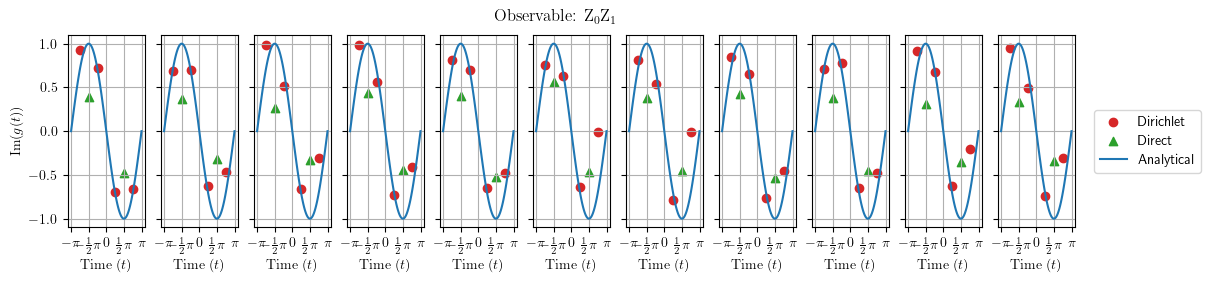

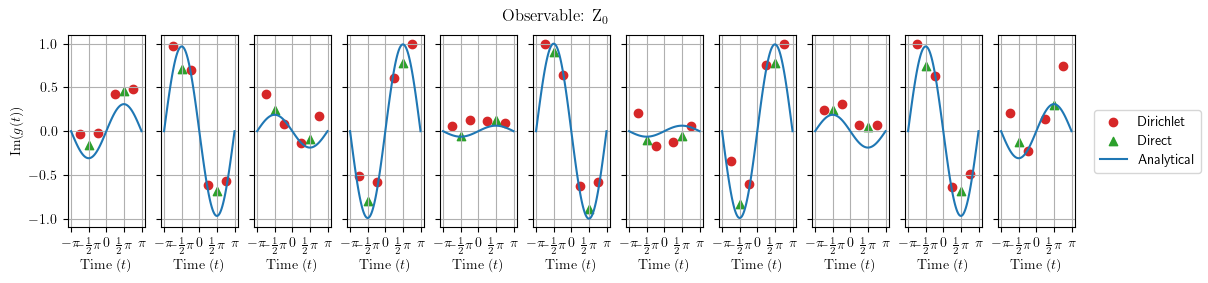

In [15]:
dirichlet_fidelities={}
direct_fidelities={}

direct_vpe_expvals_times={}
direct_vpe_expvals={}
dirichlet_vpe_expvals_times={}
dirichlet_vpe_expvals={}
phase_func_imag_analytic={}

num_linspace_points_analytic = 100
an_times= np.linspace(-np.pi, np.pi, num=num_linspace_points_analytic)

for obs in unique_obs_2qb:
    dirichlet_data=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[0]) & (vpe_data_2qb['observable']==obs)]
    direct_data=vpe_data_2qb[(vpe_data_2qb['expval_method']==vpe_data_2qb.expval_method.dropna().unique()[1]) & (vpe_data_2qb['observable']==obs)]

    for param in unique_params_2qb:
        cached_param_mask_dirichlet=dirichlet_data['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
        cached_param_mask_direct=direct_data['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
        phase_function_mask=direct_data['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
        

        phase_function_data=direct_data[phase_function_mask]
        cached_dirichlet_data=dirichlet_data[cached_param_mask_dirichlet]
        cached_direct_data=direct_data[cached_param_mask_direct]

        phase_func_imag_analytic[str(param)]=phase_function_data.cfvpe_ref_phase_function_imag_arr.to_numpy()[0]

        dirichlet_fidelities[str(param)]=np.round(cached_dirichlet_data[cached_dirichlet_data['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
        direct_fidelities[str(param)]=np.round(cached_direct_data[cached_direct_data['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)        

        dirichlet_time_mask=cached_dirichlet_data[cached_dirichlet_data['cached_value_str']=='expvalYphased_ps']
        direct_time_mask=cached_direct_data[cached_direct_data['cached_value_str']=='expvalYphased_ps']
        
        dirichlet_expval_collection, direct_expval_collection=[], []
        dirichlet_time_collection, direct_time_collection=[],[]

        for time in direct_time_mask.cached_time.unique():
            direct_expval_collection.append(direct_time_mask[direct_time_mask['cached_time']==time].cached_value.to_numpy()[0])
            direct_time_collection.append(time)
        direct_vpe_expvals[str(param)]=direct_expval_collection
        direct_vpe_expvals_times[str(param)]=direct_time_collection
        
        for time in dirichlet_time_mask.cached_time.unique():
            dirichlet_expval_collection.append(dirichlet_time_mask[dirichlet_time_mask['cached_time']==time].cached_value.to_numpy()[0])
            dirichlet_time_collection.append(time)
        dirichlet_vpe_expvals[str(param)]=dirichlet_expval_collection
        dirichlet_vpe_expvals_times[str(param)]=dirichlet_time_collection

    fig_phases, axes = plt.subplots(1,len(unique_params_2qb), sharey=True)
    for i, param in enumerate(unique_params_2qb):
        ax=axes[i]
        param_str = str(param)
    
        # Scatter plot for Dirichlet data
        ax.scatter(
            dirichlet_vpe_expvals_times[param_str],
            dirichlet_vpe_expvals[param_str],
            label="Dirichlet" if i==0 else None,
            marker='o',
            color='tab:red'
        )
        
        # Scatter plot for Direct data
        ax.scatter(
            direct_vpe_expvals_times[param_str],
            direct_vpe_expvals[param_str],
            label="Direct" if i==0 else None,
            marker='^',
            color='tab:green'
        )
        ax.plot(an_times, phase_func_imag_analytic[param_str], linestyle='-',color='tab:blue', label='Analytical' if i==0 else None)
        #ax.set_title(f"Fid: {dirichlet_fidelities[param_str]}")
        ax.set_xlabel(r"$\textrm{Time } (t)$")
        if i == 0:
            ax.set_ylabel(r"$\textrm{Im}(g(t))$")
        pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,1))
        tick_labels = [r"$-\pi$",r"$-\frac{1}{2}\pi$",r"$0$",r"$\frac{1}{2}\pi$",r"$\pi$"]#[pi_formatter(x) for x in np.linspace(-np.pi, np.pi, num=5)]
        ax.set_xticks(np.linspace(-np.pi, np.pi, num=5), tick_labels)
        ax.grid(True)
    #fig_phases.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))
    #fig_phases.tight_layout()
    fig_phases.legend(loc='right')#, bbox_to_anchor=(0.5, -0.2))
    obs_name=r"$\textrm{Z}_0\textrm{Z}_1$" if obs == unique_obs_2qb[0] else r"$\textrm{Z}_0$"
    fig_phases.suptitle(r'$\textrm{Observable: '+obs_name+'}$')

    figures_filename= notebook_path+'/mainz_phase_fn_plots/2_qubit_experiments/'+'phase_funcs_2_qb_obs_'+str(obs)+'.pdf'
    Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
    fig_phases.set_figwidth(13)
    fig_phases.set_figheight(2.5)
    plt.savefig(figures_filename, bbox_inches='tight')
    plt.show()

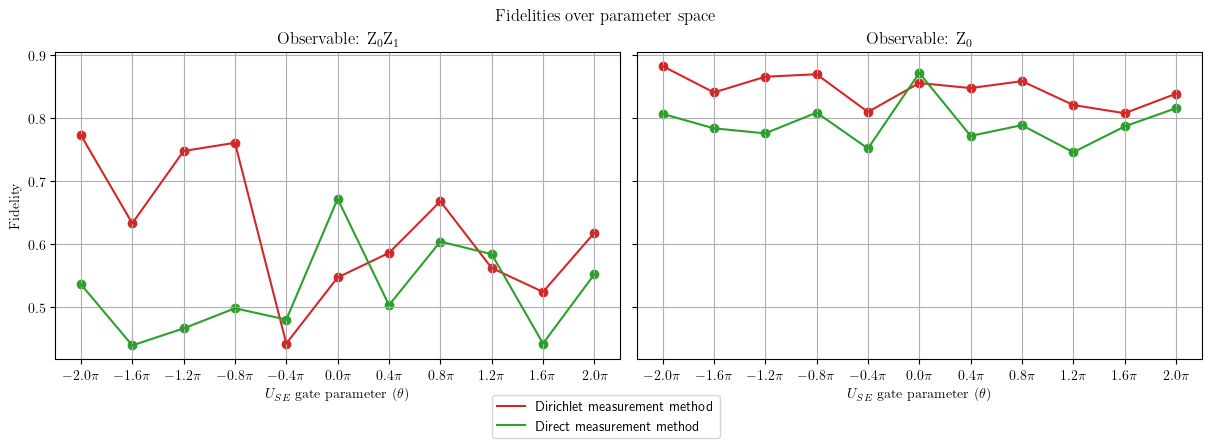

In [16]:
fids=[]
fidelities={}
params_sweep_space = np.linspace(-2*np.pi, 2*np.pi, num=len(unique_params_2qb))
params_for_fids=[param for param in params_sweep_space]

fids_for_z0_over_methods={}
fids_for_z0z1_over_methods={}
fids_for_z0_over_params_dirichlet=[]
fids_for_z0_over_params_direct=[]
fids_for_z0z1_over_params_dirichlet=[]
fids_for_z0z1_over_params_direct=[]

for idx, param in enumerate(unique_params_2qb):
    #print(param)
    param_mask=vpe_data_2qb['parameter'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    cached_param_mask=vpe_data_2qb['cached_params'].apply(lambda x: all(val is None or val in param for val in x) if x is not None else False)
    #param_filt=vpe_data[vpe_data['parameter']==param]
    param_filt=vpe_data_2qb[param_mask]
    #cached_param_filt=vpe_data[vpe_data['cached_params']==param]
    cached_param_filt=vpe_data_2qb[cached_param_mask]
    for method in param_filt['expval_method'].dropna().unique():
        #method='dirichlet'
        method_filt=param_filt[param_filt['expval_method']==method]
        cached_method_filt=cached_param_filt[cached_param_filt['expval_method']==method]
        for obs in method_filt['observable'].dropna().unique():
            #phase_func_imag_dev[obs]=method_filt[method_filt['observable']==obs].cfvpe_phase_function_imag_arr.to_numpy()[0]
            phase_func_imag_analytic[obs]=method_filt[method_filt['observable']==obs].cfvpe_ref_phase_function_imag_arr.to_numpy()[0]

            cached_obs_filt=cached_method_filt[cached_method_filt['observable']==obs]
            mask=cached_obs_filt[cached_obs_filt['cached_value_str']=='expvalYphased_ps']
            fidelities[obs]=np.round(cached_obs_filt[cached_obs_filt['cached_value_str']=='fidelity'].cached_value.to_numpy()[0], 3)
            fids.append(fidelities[obs])

        #print('fidelities:',fidelities)
        fids_for_z0_over_methods[method]=fidelities[unique_obs_2qb[0]]
        fids_for_z0z1_over_methods[method]=fidelities[unique_obs_2qb[1]]
    fids_for_z0_over_params_dirichlet.append(fids_for_z0_over_methods['dirichlet'])
    fids_for_z0_over_params_direct.append(fids_for_z0_over_methods['direct'])
    fids_for_z0z1_over_params_dirichlet.append(fids_for_z0z1_over_methods['dirichlet'])
    fids_for_z0z1_over_params_direct.append(fids_for_z0z1_over_methods['direct'])


fig_dirichlet, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4),layout='constrained',sharey=True)

ax1.plot(params_for_fids, fids_for_z0_over_params_dirichlet, linestyle="-", color='tab:red',label="Dirichlet measurement method")
ax1.plot(params_for_fids, fids_for_z0_over_params_direct, linestyle="-",color='tab:green',label="Direct measurement method")
ax1.scatter(params_for_fids, fids_for_z0_over_params_dirichlet, color='tab:red')
ax1.scatter(params_for_fids, fids_for_z0_over_params_direct, color='tab:green')
ax1.set_xlabel(r'$U_{SE}\textrm{ gate parameter }(\theta)$')
ax1.set_ylabel(r'$\textrm{Fidelity}$')
ax1.set_title(r'$\textrm{Observable: Z}_0\textrm{Z}_1$')
assert '1.0 [Z0 Z1]'==unique_obs_2qb[0]

pi_formatter = lambda x: r"${}\pi$".format(np.round(x / np.pi,2))
tick_labels = [pi_formatter(x) for x in params_for_fids]
ax1.set_xticks(params_for_fids, tick_labels)
ax1.grid(True)

ax2.plot(params_for_fids, fids_for_z0z1_over_params_dirichlet, linestyle="-", color='tab:red')
ax2.plot(params_for_fids, fids_for_z0z1_over_params_direct, linestyle="-",color='tab:green')
ax2.scatter(params_for_fids, fids_for_z0z1_over_params_dirichlet, color='tab:red')
ax2.scatter(params_for_fids, fids_for_z0z1_over_params_direct, color='tab:green')

ax2.set_xlabel(r'$U_{SE}\textrm{ gate parameter }(\theta)$')
ax2.set_title(r'$\textrm{Observable: Z}_0$')
assert '1.0 [Z0]'==unique_obs_2qb[1]
ax2.set_xticks(params_for_fids, tick_labels)
ax2.grid(True)

fig_dirichlet.legend(bbox_to_anchor=(0.5, -0.1), loc='outside lower center')
fig_dirichlet.suptitle(r'$\textrm{Fidelities over parameter space}$')
fig_dirichlet.set_figwidth(12)
fig_dirichlet.set_figheight(4)

#fig_dirichlet.show()
from pathlib import Path
figures_filename= notebook_path+'/mainz_phase_fn_plots/2_qubit_experiments/'+'fidelities_2qb.pdf'
Path(figures_filename).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_filename, bbox_inches='tight')
#fig_dirichlet.legend(loc='outside lower center')
plt.show()